# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'
data_ID = "R5KrjnANiKVhLWAkpXhNBe"

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:14<00:00, 4.01KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

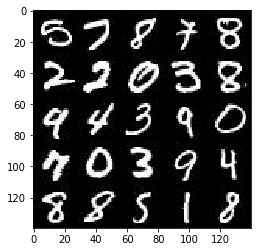

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

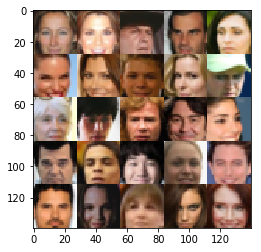

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(
        tf.float32, (None, image_width, image_height, image_channels
                    ), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learnrate = tf.placeholder(tf.float32, name='learnrate')
    return inputs_real, inputs_z, learnrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = .01
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=1, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits      
#     x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
#     x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
#     flatten = tf.reshape(relu3, (-1, 7*7*512))
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = .01
    with tf.variable_scope('generator',reuse = not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1)
        x1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2)
        x2 = tf.maximum(alpha * x2, x2)
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3)
        x3 = tf.maximum(alpha * x3, x3)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        return out
#         x1 = tf.layers.batch_normalization(x1, training=True)
#         x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='SAME')
#         x2 = tf.layers.batch_normalization(x2, training=True)
#         logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='SAME')

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_model_real)
    ))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
    ))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
        ))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if data_image_mode == "RGB":
        use=3
    else:
        use=1
#     datashape3 was use
    input_real, input_z, learnrate = model_inputs(
    data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps+=1
                batch_images*=2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    gen_samples = sess.run(
                                   generator(input_z, z_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                if steps % 100 == 0:
                    show_generator_output(
                        sess=sess, n_images = 10, input_z = input_z, 
                        out_channel_dim = data_shape[3], image_mode = data_image_mode
                    )
    return losses, samples

#     image_width = data_shape[1]
#     image_height = data_shape[2]
#     image_channels = data_shape[3]
#     input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
#     d_loss, g_loss = model_loss(input_real, input_z, image_channels)
#     d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
#     tot_batches = data_shape[0] // batch_size
#     steps=0
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
#         for epoch_i in range(epoch_count):
#             for batch_images in get_batches(batch_size):
#                 steps+=1
#                 batch_images = batch_images*2
#                 batch_z = np.random.uniform(-1,1, size = (batch_size, z_dim))
#                 _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z,})
#                 _ = sess.run(g_train_opt, feed_dict = {input_z: batch_z})
#                 if steps % every100 == 0:
#                     show_generator_output(sess=sess, n_images = 10, input_z = input_z, out_channel_dim = image_channels, image_mode = data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 0.6756
Epoch 1/2... Discriminator Loss: 0.1501... Generator Loss: 2.0147
Epoch 1/2... Discriminator Loss: 0.0237... Generator Loss: 3.9350
Epoch 1/2... Discriminator Loss: 0.0120... Generator Loss: 4.7079
Epoch 1/2... Discriminator Loss: 0.0049... Generator Loss: 5.6055
Epoch 1/2... Discriminator Loss: 0.0100... Generator Loss: 4.9520
Epoch 1/2... Discriminator Loss: 0.0131... Generator Loss: 4.4926
Epoch 1/2... Discriminator Loss: 0.0015... Generator Loss: 10.7298
Epoch 1/2... Discriminator Loss: 0.0029... Generator Loss: 6.0297
Epoch 1/2... Discriminator Loss: 0.0126... Generator Loss: 4.5544


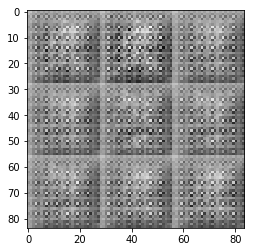

Epoch 1/2... Discriminator Loss: 0.0217... Generator Loss: 4.5741
Epoch 1/2... Discriminator Loss: 0.0277... Generator Loss: 4.3818
Epoch 1/2... Discriminator Loss: 0.0249... Generator Loss: 4.4613
Epoch 1/2... Discriminator Loss: 0.0265... Generator Loss: 4.4963
Epoch 1/2... Discriminator Loss: 0.0243... Generator Loss: 4.4755
Epoch 1/2... Discriminator Loss: 0.0231... Generator Loss: 4.6833
Epoch 1/2... Discriminator Loss: 0.0179... Generator Loss: 4.9822
Epoch 1/2... Discriminator Loss: 0.0171... Generator Loss: 4.9776
Epoch 1/2... Discriminator Loss: 0.0150... Generator Loss: 5.0113
Epoch 1/2... Discriminator Loss: 0.0193... Generator Loss: 4.5793


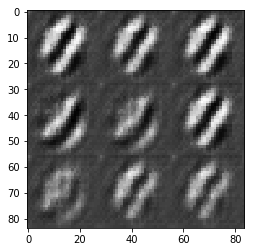

Epoch 1/2... Discriminator Loss: 0.0132... Generator Loss: 5.2181
Epoch 1/2... Discriminator Loss: 0.0120... Generator Loss: 5.2714
Epoch 1/2... Discriminator Loss: 0.0201... Generator Loss: 4.2605
Epoch 1/2... Discriminator Loss: 0.0128... Generator Loss: 5.2949
Epoch 1/2... Discriminator Loss: 0.0481... Generator Loss: 3.1378
Epoch 1/2... Discriminator Loss: 0.0218... Generator Loss: 6.7782
Epoch 1/2... Discriminator Loss: 0.0216... Generator Loss: 5.2519
Epoch 1/2... Discriminator Loss: 0.0182... Generator Loss: 5.3258
Epoch 1/2... Discriminator Loss: 0.0349... Generator Loss: 4.3827
Epoch 1/2... Discriminator Loss: 0.0491... Generator Loss: 3.6599


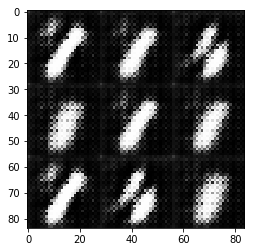

Epoch 1/2... Discriminator Loss: 0.0112... Generator Loss: 5.4378
Epoch 1/2... Discriminator Loss: 0.0159... Generator Loss: 5.2675
Epoch 1/2... Discriminator Loss: 0.0141... Generator Loss: 4.9282
Epoch 1/2... Discriminator Loss: 0.0182... Generator Loss: 4.8898
Epoch 1/2... Discriminator Loss: 0.0266... Generator Loss: 4.7509
Epoch 1/2... Discriminator Loss: 0.0127... Generator Loss: 5.5832
Epoch 1/2... Discriminator Loss: 0.0091... Generator Loss: 5.7578
Epoch 1/2... Discriminator Loss: 0.0140... Generator Loss: 5.2950
Epoch 1/2... Discriminator Loss: 0.0110... Generator Loss: 5.3676
Epoch 1/2... Discriminator Loss: 0.0193... Generator Loss: 4.8209


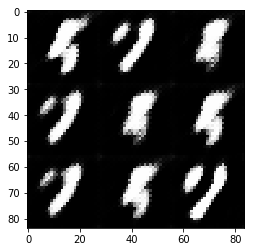

Epoch 1/2... Discriminator Loss: 0.0320... Generator Loss: 4.0837
Epoch 1/2... Discriminator Loss: 0.0107... Generator Loss: 5.5546
Epoch 1/2... Discriminator Loss: 0.0556... Generator Loss: 3.2562
Epoch 1/2... Discriminator Loss: 0.0100... Generator Loss: 5.6520
Epoch 1/2... Discriminator Loss: 0.0205... Generator Loss: 5.2202
Epoch 1/2... Discriminator Loss: 0.0169... Generator Loss: 4.9050
Epoch 2/2... Discriminator Loss: 0.0230... Generator Loss: 4.6368
Epoch 2/2... Discriminator Loss: 0.0234... Generator Loss: 4.6996
Epoch 2/2... Discriminator Loss: 0.0193... Generator Loss: 4.4840
Epoch 2/2... Discriminator Loss: 0.0145... Generator Loss: 5.3367


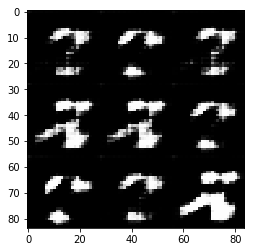

Epoch 2/2... Discriminator Loss: 0.0292... Generator Loss: 4.1181
Epoch 2/2... Discriminator Loss: 0.0115... Generator Loss: 5.3014
Epoch 2/2... Discriminator Loss: 0.0212... Generator Loss: 5.4465
Epoch 2/2... Discriminator Loss: 0.0187... Generator Loss: 4.8730
Epoch 2/2... Discriminator Loss: 0.0110... Generator Loss: 7.3350
Epoch 2/2... Discriminator Loss: 0.0100... Generator Loss: 5.5133
Epoch 2/2... Discriminator Loss: 0.0066... Generator Loss: 5.9619
Epoch 2/2... Discriminator Loss: 0.0081... Generator Loss: 5.5681
Epoch 2/2... Discriminator Loss: 0.0133... Generator Loss: 5.4264
Epoch 2/2... Discriminator Loss: 0.0076... Generator Loss: 5.5885


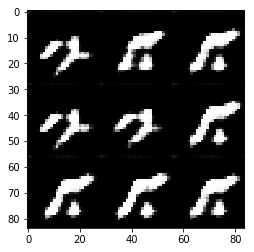

Epoch 2/2... Discriminator Loss: 0.0084... Generator Loss: 5.5456
Epoch 2/2... Discriminator Loss: 0.0101... Generator Loss: 5.3799
Epoch 2/2... Discriminator Loss: 0.0109... Generator Loss: 5.2833
Epoch 2/2... Discriminator Loss: 0.0032... Generator Loss: 6.4688
Epoch 2/2... Discriminator Loss: 0.0037... Generator Loss: 6.2028
Epoch 2/2... Discriminator Loss: 0.0039... Generator Loss: 6.1196
Epoch 2/2... Discriminator Loss: 0.0031... Generator Loss: 6.6073
Epoch 2/2... Discriminator Loss: 0.0031... Generator Loss: 6.5996
Epoch 2/2... Discriminator Loss: 0.0045... Generator Loss: 6.0406
Epoch 2/2... Discriminator Loss: 0.0108... Generator Loss: 5.3080


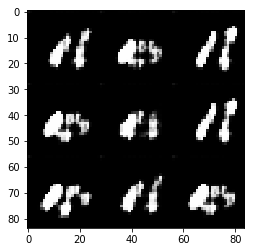

Epoch 2/2... Discriminator Loss: 0.0046... Generator Loss: 6.2157
Epoch 2/2... Discriminator Loss: 0.0072... Generator Loss: 5.9102
Epoch 2/2... Discriminator Loss: 0.0044... Generator Loss: 6.3977
Epoch 2/2... Discriminator Loss: 0.0088... Generator Loss: 6.1153
Epoch 2/2... Discriminator Loss: 0.0090... Generator Loss: 5.9652
Epoch 2/2... Discriminator Loss: 0.1322... Generator Loss: 2.3665
Epoch 2/2... Discriminator Loss: 0.0559... Generator Loss: 9.7109
Epoch 2/2... Discriminator Loss: 0.0066... Generator Loss: 6.0592
Epoch 2/2... Discriminator Loss: 0.0059... Generator Loss: 5.8238
Epoch 2/2... Discriminator Loss: 0.0084... Generator Loss: 5.2708


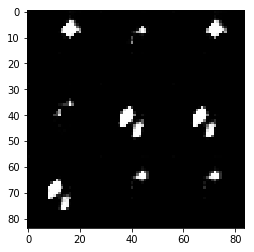

Epoch 2/2... Discriminator Loss: 0.0112... Generator Loss: 5.0421
Epoch 2/2... Discriminator Loss: 0.0470... Generator Loss: 4.5712
Epoch 2/2... Discriminator Loss: 0.0321... Generator Loss: 4.5323
Epoch 2/2... Discriminator Loss: 0.0114... Generator Loss: 5.3329
Epoch 2/2... Discriminator Loss: 0.0085... Generator Loss: 5.8046
Epoch 2/2... Discriminator Loss: 0.0172... Generator Loss: 6.1464
Epoch 2/2... Discriminator Loss: 0.0043... Generator Loss: 6.1108
Epoch 2/2... Discriminator Loss: 0.1052... Generator Loss: 7.1618
Epoch 2/2... Discriminator Loss: 0.1679... Generator Loss: 6.0082
Epoch 2/2... Discriminator Loss: 0.0225... Generator Loss: 4.5757


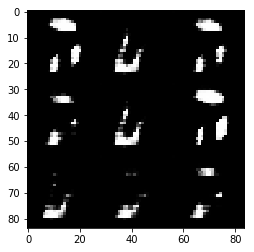

Epoch 2/2... Discriminator Loss: 0.0488... Generator Loss: 4.2431
Epoch 2/2... Discriminator Loss: 0.0342... Generator Loss: 4.5215
Epoch 2/2... Discriminator Loss: 0.0254... Generator Loss: 4.8304


In [12]:
batch_size = 128
z_dim = 1
learning_rate = .0001
beta1 = .4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7506... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 0.1264... Generator Loss: 2.2759
Epoch 1/1... Discriminator Loss: 0.0395... Generator Loss: 3.5457
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 4.4388
Epoch 1/1... Discriminator Loss: 0.0089... Generator Loss: 5.1063
Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 5.3395
Epoch 1/1... Discriminator Loss: 0.0095... Generator Loss: 5.2676
Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 5.2260
Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 5.8951
Epoch 1/1... Discriminator Loss: 0.0045... Generator Loss: 6.1261


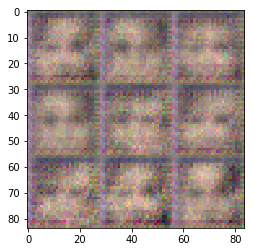

Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 6.2345
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 6.4127
Epoch 1/1... Discriminator Loss: 12.1864... Generator Loss: 23.5255
Epoch 1/1... Discriminator Loss: 0.0758... Generator Loss: 4.1903
Epoch 1/1... Discriminator Loss: 0.0558... Generator Loss: 4.0112
Epoch 1/1... Discriminator Loss: 0.0482... Generator Loss: 4.3029
Epoch 1/1... Discriminator Loss: 0.0505... Generator Loss: 4.1068
Epoch 1/1... Discriminator Loss: 0.0479... Generator Loss: 4.8115
Epoch 1/1... Discriminator Loss: 0.0812... Generator Loss: 3.5975
Epoch 1/1... Discriminator Loss: 0.1135... Generator Loss: 3.2784


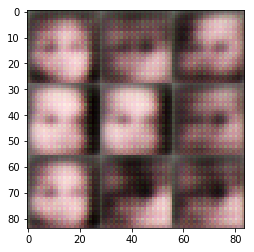

Epoch 1/1... Discriminator Loss: 0.0899... Generator Loss: 3.5084
Epoch 1/1... Discriminator Loss: 0.0875... Generator Loss: 3.5030
Epoch 1/1... Discriminator Loss: 0.0736... Generator Loss: 3.7674
Epoch 1/1... Discriminator Loss: 0.0798... Generator Loss: 3.8195
Epoch 1/1... Discriminator Loss: 0.0765... Generator Loss: 3.5089
Epoch 1/1... Discriminator Loss: 0.0932... Generator Loss: 3.2452
Epoch 1/1... Discriminator Loss: 0.0847... Generator Loss: 3.2412
Epoch 1/1... Discriminator Loss: 0.1253... Generator Loss: 4.8994
Epoch 1/1... Discriminator Loss: 0.0820... Generator Loss: 3.3417
Epoch 1/1... Discriminator Loss: 0.0640... Generator Loss: 3.9995


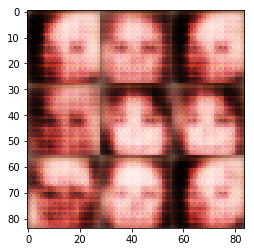

Epoch 1/1... Discriminator Loss: 0.0872... Generator Loss: 4.2450
Epoch 1/1... Discriminator Loss: 0.0478... Generator Loss: 3.9149
Epoch 1/1... Discriminator Loss: 0.0723... Generator Loss: 3.7116
Epoch 1/1... Discriminator Loss: 0.0670... Generator Loss: 3.8191
Epoch 1/1... Discriminator Loss: 0.0934... Generator Loss: 3.1138
Epoch 1/1... Discriminator Loss: 0.0663... Generator Loss: 3.7033
Epoch 1/1... Discriminator Loss: 0.0375... Generator Loss: 4.1771
Epoch 1/1... Discriminator Loss: 0.0681... Generator Loss: 3.2908
Epoch 1/1... Discriminator Loss: 0.0618... Generator Loss: 3.7887
Epoch 1/1... Discriminator Loss: 0.0796... Generator Loss: 5.4721


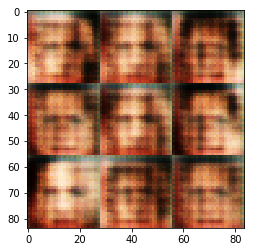

Epoch 1/1... Discriminator Loss: 2.0681... Generator Loss: 0.3098
Epoch 1/1... Discriminator Loss: 0.0624... Generator Loss: 4.0581
Epoch 1/1... Discriminator Loss: 0.1739... Generator Loss: 2.7004
Epoch 1/1... Discriminator Loss: 0.0645... Generator Loss: 3.8051
Epoch 1/1... Discriminator Loss: 0.0844... Generator Loss: 3.2887
Epoch 1/1... Discriminator Loss: 0.1017... Generator Loss: 3.1018
Epoch 1/1... Discriminator Loss: 0.0854... Generator Loss: 3.1972
Epoch 1/1... Discriminator Loss: 0.1180... Generator Loss: 2.7549
Epoch 1/1... Discriminator Loss: 0.1588... Generator Loss: 2.9446
Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 6.4611


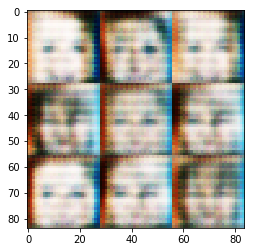

Epoch 1/1... Discriminator Loss: 0.0698... Generator Loss: 3.5413
Epoch 1/1... Discriminator Loss: 0.1213... Generator Loss: 3.1192
Epoch 1/1... Discriminator Loss: 0.1246... Generator Loss: 3.4984
Epoch 1/1... Discriminator Loss: 0.0940... Generator Loss: 3.7215
Epoch 1/1... Discriminator Loss: 0.0585... Generator Loss: 3.9218
Epoch 1/1... Discriminator Loss: 0.0586... Generator Loss: 3.6958
Epoch 1/1... Discriminator Loss: 0.0541... Generator Loss: 3.7367
Epoch 1/1... Discriminator Loss: 0.1092... Generator Loss: 3.0879
Epoch 1/1... Discriminator Loss: 0.1010... Generator Loss: 3.2145
Epoch 1/1... Discriminator Loss: 0.0799... Generator Loss: 3.4869


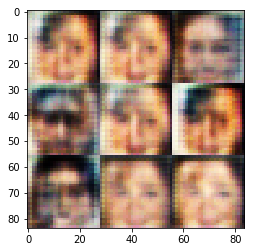

Epoch 1/1... Discriminator Loss: 0.0872... Generator Loss: 3.4151
Epoch 1/1... Discriminator Loss: 0.0704... Generator Loss: 3.9157
Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 3.7376
Epoch 1/1... Discriminator Loss: 0.1049... Generator Loss: 2.6390
Epoch 1/1... Discriminator Loss: 0.0581... Generator Loss: 4.5816
Epoch 1/1... Discriminator Loss: 0.0583... Generator Loss: 4.0896
Epoch 1/1... Discriminator Loss: 0.1497... Generator Loss: 2.4915
Epoch 1/1... Discriminator Loss: 0.2394... Generator Loss: 1.8726
Epoch 1/1... Discriminator Loss: 0.0482... Generator Loss: 4.5867
Epoch 1/1... Discriminator Loss: 0.0551... Generator Loss: 3.9870


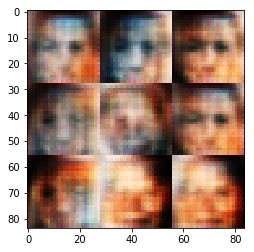

Epoch 1/1... Discriminator Loss: 0.0532... Generator Loss: 3.8618
Epoch 1/1... Discriminator Loss: 0.0704... Generator Loss: 3.1945
Epoch 1/1... Discriminator Loss: 0.1372... Generator Loss: 4.5564
Epoch 1/1... Discriminator Loss: 0.0543... Generator Loss: 3.6308
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 3.7839
Epoch 1/1... Discriminator Loss: 0.1086... Generator Loss: 5.5410
Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 0.0431... Generator Loss: 4.0894
Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 3.9311
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 3.7717


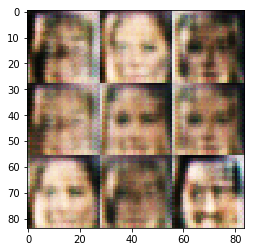

Epoch 1/1... Discriminator Loss: 0.0796... Generator Loss: 3.4085
Epoch 1/1... Discriminator Loss: 0.0682... Generator Loss: 3.7622
Epoch 1/1... Discriminator Loss: 0.0740... Generator Loss: 3.2956
Epoch 1/1... Discriminator Loss: 0.1244... Generator Loss: 2.6375
Epoch 1/1... Discriminator Loss: 0.0542... Generator Loss: 3.7791
Epoch 1/1... Discriminator Loss: 0.1112... Generator Loss: 4.7327
Epoch 1/1... Discriminator Loss: 0.0641... Generator Loss: 3.9374
Epoch 1/1... Discriminator Loss: 0.0778... Generator Loss: 4.1165
Epoch 1/1... Discriminator Loss: 0.1094... Generator Loss: 2.7539
Epoch 1/1... Discriminator Loss: 0.0275... Generator Loss: 4.6775


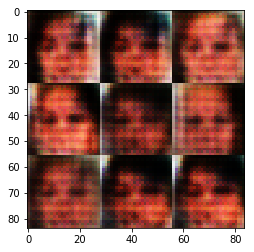

Epoch 1/1... Discriminator Loss: 0.0636... Generator Loss: 3.5048
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 3.6865
Epoch 1/1... Discriminator Loss: 0.0479... Generator Loss: 4.5909
Epoch 1/1... Discriminator Loss: 0.0537... Generator Loss: 3.8571
Epoch 1/1... Discriminator Loss: 0.0515... Generator Loss: 3.9949
Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 3.7441
Epoch 1/1... Discriminator Loss: 0.0378... Generator Loss: 4.1819
Epoch 1/1... Discriminator Loss: 0.0724... Generator Loss: 3.4937
Epoch 1/1... Discriminator Loss: 0.0415... Generator Loss: 4.0410
Epoch 1/1... Discriminator Loss: 0.0686... Generator Loss: 3.6675


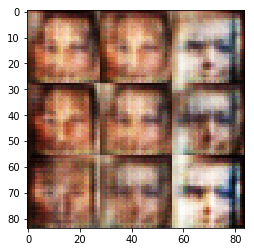

Epoch 1/1... Discriminator Loss: 0.0491... Generator Loss: 3.8719
Epoch 1/1... Discriminator Loss: 0.0390... Generator Loss: 9.5821
Epoch 1/1... Discriminator Loss: 0.0785... Generator Loss: 3.1945
Epoch 1/1... Discriminator Loss: 0.0417... Generator Loss: 4.2565
Epoch 1/1... Discriminator Loss: 0.0333... Generator Loss: 4.3893
Epoch 1/1... Discriminator Loss: 0.0539... Generator Loss: 4.1176
Epoch 1/1... Discriminator Loss: 0.0642... Generator Loss: 3.5345
Epoch 1/1... Discriminator Loss: 0.0487... Generator Loss: 4.2021
Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 4.6778
Epoch 1/1... Discriminator Loss: 0.0475... Generator Loss: 4.6525


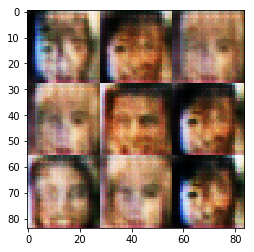

Epoch 1/1... Discriminator Loss: 0.0558... Generator Loss: 3.7320
Epoch 1/1... Discriminator Loss: 0.0352... Generator Loss: 4.3760
Epoch 1/1... Discriminator Loss: 0.0274... Generator Loss: 4.6879
Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 4.6886
Epoch 1/1... Discriminator Loss: 0.0270... Generator Loss: 4.8774
Epoch 1/1... Discriminator Loss: 5.4012... Generator Loss: 23.0526
Epoch 1/1... Discriminator Loss: 0.0223... Generator Loss: 5.9286
Epoch 1/1... Discriminator Loss: 0.0753... Generator Loss: 5.3470
Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 3.8402
Epoch 1/1... Discriminator Loss: 0.0323... Generator Loss: 4.5716


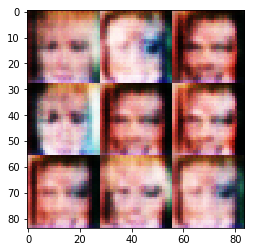

Epoch 1/1... Discriminator Loss: 0.0491... Generator Loss: 4.3791
Epoch 1/1... Discriminator Loss: 0.0641... Generator Loss: 3.8354
Epoch 1/1... Discriminator Loss: 0.0746... Generator Loss: 4.6621
Epoch 1/1... Discriminator Loss: 0.0690... Generator Loss: 3.9266
Epoch 1/1... Discriminator Loss: 0.0579... Generator Loss: 4.5105
Epoch 1/1... Discriminator Loss: 0.0647... Generator Loss: 3.5165
Epoch 1/1... Discriminator Loss: 0.0819... Generator Loss: 3.5816
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 4.0890
Epoch 1/1... Discriminator Loss: 0.0638... Generator Loss: 3.9358
Epoch 1/1... Discriminator Loss: 0.0547... Generator Loss: 4.0127


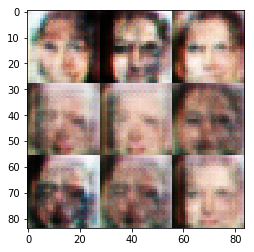

Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 3.3847
Epoch 1/1... Discriminator Loss: 0.0880... Generator Loss: 3.3698
Epoch 1/1... Discriminator Loss: 0.0635... Generator Loss: 3.8302
Epoch 1/1... Discriminator Loss: 0.0951... Generator Loss: 3.3017
Epoch 1/1... Discriminator Loss: 0.0470... Generator Loss: 3.9604
Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 4.5113
Epoch 1/1... Discriminator Loss: 0.0316... Generator Loss: 4.2644
Epoch 1/1... Discriminator Loss: 0.0519... Generator Loss: 3.9125
Epoch 1/1... Discriminator Loss: 0.0541... Generator Loss: 3.4974
Epoch 1/1... Discriminator Loss: 0.0760... Generator Loss: 3.4000


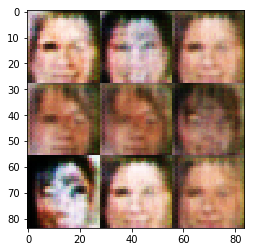

Epoch 1/1... Discriminator Loss: 0.0434... Generator Loss: 3.9617
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 4.3002
Epoch 1/1... Discriminator Loss: 0.0340... Generator Loss: 4.3851
Epoch 1/1... Discriminator Loss: 0.0655... Generator Loss: 3.7075
Epoch 1/1... Discriminator Loss: 0.0354... Generator Loss: 4.4008
Epoch 1/1... Discriminator Loss: 0.0699... Generator Loss: 4.1079
Epoch 1/1... Discriminator Loss: 0.0443... Generator Loss: 4.1239
Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 4.3734
Epoch 1/1... Discriminator Loss: 0.0347... Generator Loss: 4.2892
Epoch 1/1... Discriminator Loss: 0.0838... Generator Loss: 2.9573


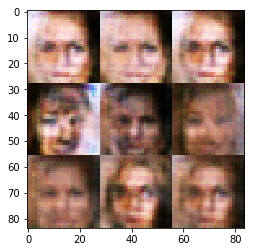

Epoch 1/1... Discriminator Loss: 0.0623... Generator Loss: 3.4831
Epoch 1/1... Discriminator Loss: 0.0550... Generator Loss: 4.6464
Epoch 1/1... Discriminator Loss: 0.0390... Generator Loss: 3.8916
Epoch 1/1... Discriminator Loss: 0.0393... Generator Loss: 4.2846
Epoch 1/1... Discriminator Loss: 0.0376... Generator Loss: 4.9062
Epoch 1/1... Discriminator Loss: 0.0210... Generator Loss: 5.2548
Epoch 1/1... Discriminator Loss: 0.0396... Generator Loss: 4.7114
Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 5.9430


In [13]:
batch_size = 128
z_dim = 3
learning_rate = .0001
beta1 = .4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.